In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm # For colormaps like Reds
import networkx as nx
from mne.channels import make_standard_montage
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors

ModuleNotFoundError: No module named 'mne'

# SHAP Analysis for Site Classification

## Objective
Understand WHAT the model learns to distinguish hospitals - which EEG features and electrode regions are most important for site classification.

## Methodology
- **SHAP (SHapley Additive exPlanations)**: TreeExplainer for CatBoost
- **Aggregation**: Mean absolute SHAP values across all samples and folds
- **Visualization**: Custom EEG topography plots showing electrode connectivity and power distributions

## Visualizations Created
1. **Feature Overview**: 7×5 grid showing all coherence bands, power bands, and covariance
2. **Frequency Band Aggregation**: Summed importance by traditional EEG bands (delta, theta, alpha, beta, gamma)
3. **Top Features Heatmap**: Hospital × Feature importance matrix

## Key Findings

## Interpretation



In [3]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [4]:
def extract_hospital_features(data_series: pd.Series, argument: str) -> pd.Series:
    """
    Filters and renames indices of a Pandas Series based on a specified argument
    related to hospital features like power (pow), coherence (coh), or covariance (cov).
    This version is adapted to work with a Pandas Series as input.
    """
    selected_indices_rename_map = {}
    original_indices_to_select = []

    arg_parts = argument.split('_')
    feature_type_from_arg = arg_parts[0]

    # Validate argument structure and then process the series
    if feature_type_from_arg == "pow":
        if len(arg_parts) < 2:
            raise ValueError("Argument for 'pow' must specify a band (e.g., 'pow_0_2').")
        
        band_to_match = "_".join(arg_parts[1:])
        prefix_to_match = f"pow_"
        suffix_to_match = f"_{band_to_match}"
        
        for idx_name in data_series.index:
            if not isinstance(idx_name, str): # Skip non-string indices
                continue
            if idx_name.startswith(prefix_to_match) and idx_name.endswith(suffix_to_match):
                # Ensure there's content (electrode name) between prefix and suffix
                if len(idx_name) > len(prefix_to_match) + len(suffix_to_match):
                    new_idx_name = idx_name[len(prefix_to_match):-len(suffix_to_match)]
                    selected_indices_rename_map[idx_name] = new_idx_name
                    original_indices_to_select.append(idx_name)

    elif feature_type_from_arg == "coh":
        if len(arg_parts) < 2:
            raise ValueError("Argument for 'coh' must specify a band (e.g., 'coh_0_2').")
            
        band_to_match = "_".join(arg_parts[1:])
        prefix_to_match = f"coh_"
        suffix_to_match = f"_{band_to_match}"

        for idx_name in data_series.index:
            if not isinstance(idx_name, str): # Skip non-string indices
                continue
            if idx_name.startswith(prefix_to_match) and idx_name.endswith(suffix_to_match):
                # Ensure there's content (electrode pair) between prefix and suffix
                if len(idx_name) > len(prefix_to_match) + len(suffix_to_match):
                    new_idx_name = idx_name[len(prefix_to_match):-len(suffix_to_match)]
                    selected_indices_rename_map[idx_name] = new_idx_name
                    original_indices_to_select.append(idx_name)

    elif feature_type_from_arg == "cov":
        if argument != "cov":
            raise ValueError("Argument for 'cov' should be exactly 'cov'.")
            
        prefix_to_match = f"cov_"

        for idx_name in data_series.index:
            if not isinstance(idx_name, str): # Skip non-string indices
                continue
            if idx_name.startswith(prefix_to_match):
                # Ensure there's content (electrode name/pair) after prefix
                if len(idx_name) > len(prefix_to_match):
                    new_idx_name = idx_name[len(prefix_to_match):]
                    selected_indices_rename_map[idx_name] = new_idx_name
                    original_indices_to_select.append(idx_name)
    else:
        raise ValueError(
            f"Unknown feature type '{feature_type_from_arg}' in argument. "
            "Supported types are 'pow', 'coh', 'cov'."
        )

    if not original_indices_to_select:
        # Return an empty Series, preserving name and dtype from the input series
        return pd.Series(name=data_series.name, dtype=data_series.dtype)

    # Create a new Series with the selected items.
    # Using .loc[list_of_labels] preserves the Series name if data_series had one.
    result_series = data_series.loc[original_indices_to_select].copy()
    
    # Rename the index of the new Series
    result_series.rename(index=selected_indices_rename_map, inplace=True)
    
    return result_series

def create_channel_matrix(feature_importance, channels):    
    # Initialize matrix with zeros
    n_channels = len(channels)
    matrix = np.zeros((n_channels, n_channels))
    
    # Fill matrix with importance values
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            feature_name1 = f'{ch1}_{ch2}'
            feature_name2 = f'{ch2}_{ch1}'
            
            if feature_name1 in feature_importance.index:
                matrix[i, j] = feature_importance[feature_name1]
            elif feature_name2 in feature_importance.index:
                matrix[i, j] = feature_importance[feature_name2]
    
    return matrix


def plot_electrode_pairs(
    data_series: pd.Series,
    ax: plt.Axes,
    plot_title: str,
    channels: list,
    vmin: float,
    vmax: float,
    node_size: int = 1200,
    node_font_size: int = 14,
    edge_width: float = 1.5,
):
    """
    Plots electrode connectivity graph on a 2D sensor layout on a given Axes object.
    """
    ax.clear()  # Clear the axes for fresh plotting

    # 1. Create the connectivity matrix
    matrix = create_channel_matrix(data_series, channels)
    
    # 2. Channel Positions 
    channel_pos = {
        'Fp1': (-0.5,  1.0),
        'Fp2': ( 0.5,  1.0),
        'F7' : (-1.0,  0.5),
        'F3' : (-0.5,  0.5),
        'Fz' : ( 0.0,  0.5),
        'F4' : ( 0.5,  0.5),
        'F8' : ( 1.0,  0.5),
        'T3' : (-1.2,  0.0),
        'C3' : (-0.5,  0.0),
        'Cz' : ( 0.0,  0.0),
        'C4' : ( 0.5,  0.0),
        'T4' : ( 1.2,  0.0),
        'T5' : (-1.0, -0.5),
        'P3' : (-0.5, -0.5),
        'Pz' : ( 0.0, -0.5),
        'P4' : ( 0.5, -0.5),
        'T6' : ( 1.0, -0.5),
        'O1' : (-0.5, -1.0),
        'O2' : ( 0.5, -1.0),
    }
    
    # 3. Create Graph using NetworkX
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(channels) 
                                
    edges_to_draw = [] # List of (ch1, ch2, weight)
    
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            if i < j: 
                weight = matrix[j, i] # Assuming matrix_thresh is symmetric or this convention is intended
                if weight > 0:
                    if ch1 in channel_pos and ch2 in channel_pos:
                        edges_to_draw.append((ch1, ch2, weight))

    # Add edges with weights to the graph
    for u, v, w in edges_to_draw:
        G.add_edge(u, v, weight=w)

    # 5. Drawing on the provided Axes (ax)
    ax.set_facecolor("white")
    ax.set_title(plot_title, fontsize=node_font_size + 6, pad=3) # pad for spacing

    # Nodes to draw (only those with positions)
    drawable_nodes = list(channel_pos.keys())
    
    # Edges and their corresponding weights for coloring
    # Ensure we only try to draw edges between nodes that are in `drawable_nodes`
    final_edges = []
    final_weights = []
    for u, v, data in G.edges(data=True):
        if u in drawable_nodes and v in drawable_nodes:
            final_edges.append((u,v))
            final_weights.append(data['weight'])

    edge_colors = []
    if final_weights:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        edge_colors = [cm.Reds(norm(w)) for w in final_weights]

    # Draw the graph components
    nx.draw_networkx_nodes(G, channel_pos, ax=ax, nodelist=drawable_nodes, 
                           node_size=node_size, node_color='white', edgecolors='black', linewidths=0.8)
    nx.draw_networkx_labels(G, channel_pos, ax=ax, labels={n: n for n in drawable_nodes}, 
                            font_size=node_font_size, font_color='black')
    
    if final_edges:
        nx.draw_networkx_edges(G, channel_pos, ax=ax, edgelist=final_edges, 
                               edge_color=edge_colors, width=edge_width, arrows=False)
    
    ax.axis('off')
    # Extract x and y coordinates from positions
    xs = [channel_pos[ch][0] for ch in drawable_nodes]
    ys = [channel_pos[ch][1] for ch in drawable_nodes]
    
    # Set limits with padding
    pad = 0.2  # adjust padding as needed
    ax.set_xlim(min(xs) - pad, max(xs) + pad)
    ax.set_ylim(min(ys) - pad, max(ys) + pad)

def plot_channel_values_as_nodes(
    data_series: pd.Series,
    ax: plt.Axes,
    plot_title: str,
    channels: list,
    vmin: float,
    vmax: float,
    node_size: int = 1200,
    node_font_size: int = 14,
    edge_width: float = 1.5,
):
    """
    Plots EEG channel values as colored nodes on a 2D topological layout.
    The color of each node represents the value from data_series for that channel.
    No edges (connections) are drawn between nodes.
    """
    ax.clear()  # Clear the axes for fresh plotting

    # 1. Create the connectivity matrix
    matrix = create_channel_matrix(data_series, channels)
    
    # 2. Channel Positions 
    channel_pos = {
        'Fp1': (-0.5,  1.0),
        'Fp2': ( 0.5,  1.0),
        'F7' : (-1.0,  0.5),
        'F3' : (-0.5,  0.5),
        'Fz' : ( 0.0,  0.5),
        'F4' : ( 0.5,  0.5),
        'F8' : ( 1.0,  0.5),
        'T3' : (-1.2,  0.0),
        'C3' : (-0.5,  0.0),
        'Cz' : ( 0.0,  0.0),
        'C4' : ( 0.5,  0.0),
        'T4' : ( 1.2,  0.0),
        'T5' : (-1.0, -0.5),
        'P3' : (-0.5, -0.5),
        'Pz' : ( 0.0, -0.5),
        'P4' : ( 0.5, -0.5),
        'T6' : ( 1.0, -0.5),
        'O1' : (-0.5, -1.0),
        'O2' : ( 0.5, -1.0),
    }
    
    valid_channels = []
    node_values_for_coloring = []
    for ch_name in channels:
        if ch_name in data_series.index and ch_name in channel_pos:
            valid_channels.append(ch_name)
            node_values_for_coloring.append(data_series[ch_name])
       
    # --- Node Coloring ---
    # Normalize values for colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("Reds")
    node_colors = [cmap(norm(value)) for value in node_values_for_coloring]

    # --- Drawing ---
    ax.set_facecolor("white")
    if plot_title:
        ax.set_title(plot_title, fontsize=node_font_size + 6, pad=3)

    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(valid_channels)
    nx.draw_networkx_nodes(G, channel_pos, ax=ax, nodelist=valid_channels, 
                           node_size=node_size, node_color=node_colors, edgecolors='black', linewidths=0.8)
    nx.draw_networkx_labels(G, channel_pos, ax=ax, labels={n: n for n in valid_channels}, 
                            font_size=node_font_size, font_color='black')
    
    ax.axis('off')
    
    # Extract x and y coordinates from positions
    xs = [channel_pos[ch][0] for ch in valid_channels]
    ys = [channel_pos[ch][1] for ch in valid_channels]
    
    # Set limits with padding
    pad = 0.2  # adjust padding as needed
    ax.set_xlim(min(xs) - pad, max(xs) + pad)
    ax.set_ylim(min(ys) - pad, max(ys) + pad)
    
    
def plot_eeg_feature_overview(
    features_series: pd.Series,
    figure_title: str = "EEG Feature Overview",
):
    """
    Creates a large figure with subplots for COH, POW, and COV features.
    Assumes 14 COH plots, 14 POW plots, and 1 COV plot.
    The layout is 6 rows by 5 columns.
    """
    FREQ_BANDS = np.array(
        [
            [0.5, 2], [1, 3], [2, 4], [3, 6], [4, 8],
            [6, 10], [8, 13], [10, 15], [13, 18], [15, 21], [18, 24], [21, 27], [24, 30], [27, 40]
        ]
    )

    channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

    
    nrows = 7
    ncols = 5
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 6.4, nrows * 6.0), squeeze=False)

    plot_idx = 0

    vmin_global = features_series.min()
    vmax_global = features_series.max()
    # --- 1. Coherence Plots ---
    for i, (f_low, f_high) in enumerate(FREQ_BANDS):
        r, c = divmod(plot_idx, ncols)
        if r >= nrows: # Safety break, should not be hit with fixed nrows/ncols for 29 plots
            print(f"Warning: Ran out of subplot rows for COH plot {i+1}.")
            break
        ax = axs[r, c]
        series = extract_hospital_features(features_series, f"coh_{int(float(f_low))}_{int(float(f_high))}")
        plot_electrode_pairs(
                series, 
                ax, 
                f"Coh: {int(f_low)}-{int(f_high)} Hz", 
                channels, 
                vmin=vmin_global, 
                vmax=vmax_global
        )
        plot_idx += 1
        
    r, c = divmod(plot_idx, ncols)
    axs[r, c].axis('off')
    plot_idx += 1
    
    # --- 2. Power Plots ---
    for i, (f_low, f_high) in enumerate(FREQ_BANDS):
        r, c = divmod(plot_idx, ncols)
        if r >= nrows:
            print(f"Warning: Ran out of subplot rows for POW plot {i+1}.")
            break
        ax = axs[r, c]
        series = extract_hospital_features(features_series, f"pow_{int(float(f_low))}_{int(float(f_high))}")
        plot_channel_values_as_nodes(
            data_series=series,
            ax=ax,
            plot_title=f"Pow: {int(f_low)}-{int(f_high)} Hz",
            channels=channels,
            vmin=vmin_global,
            vmax=vmax_global
        )
        plot_idx += 1
        
    r, c = divmod(plot_idx, ncols)
    axs[r, c].axis('off')
    plot_idx += 1
        
    # --- 3. Covariance Plot ---
    # Expected to fill 1 slot: (5,3)
    r, c = divmod(plot_idx, ncols)
    if r < nrows:
        ax = axs[r, c]
        series = extract_hospital_features(features_series, f"cov")
        plot_electrode_pairs(
                series, 
                ax, 
                f"Cov", 
                channels, 
                vmin=vmin_global, 
                vmax=vmax_global
        )
        plot_idx += 1
    else:
        print("Warning: Ran out of subplot rows for COV plot.")


    # Turn off axes for any remaining empty subplots
    # (e.g. axs[5,4] in the 6x5 grid for 29 plots)
    while plot_idx < nrows * ncols:
        r, c = divmod(plot_idx, ncols)
        axs[r, c].axis('off')
        plot_idx += 1

    cmap = cm.Reds
    norm = colors.Normalize(vmin=vmin_global, vmax=vmax_global)

    # Create a colorbar axis on top
    cbar_ax = fig.add_axes([0.3, 0.92, 0.4, 0.02])  # [left, bottom, width, height] in figure coordinates
    cbar = colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
    
    cbar.set_label('Mean Absolute SHAP Value', fontsize=24)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.xaxis.set_label_position('top')
    
    fig.subplots_adjust(top=0.88)
    
    return fig, axs

In [5]:
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

In [6]:
ELM19_info_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_info_filtered_norm.csv'
ELM19_features_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_features_filtered_norm.csv'

In [7]:
df_info = pd.read_csv(ELM19_info_filtered_norm_path)
df_feats = pd.read_csv(ELM19_features_filtered_norm_path)

In [8]:
y = df_info['institution_id']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
hospital_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

In [1]:
shap_values = pd.read_csv("results/tables/cv_global_shap_summary.csv")
shap_values.index = hospital_names

NameError: name 'pd' is not defined

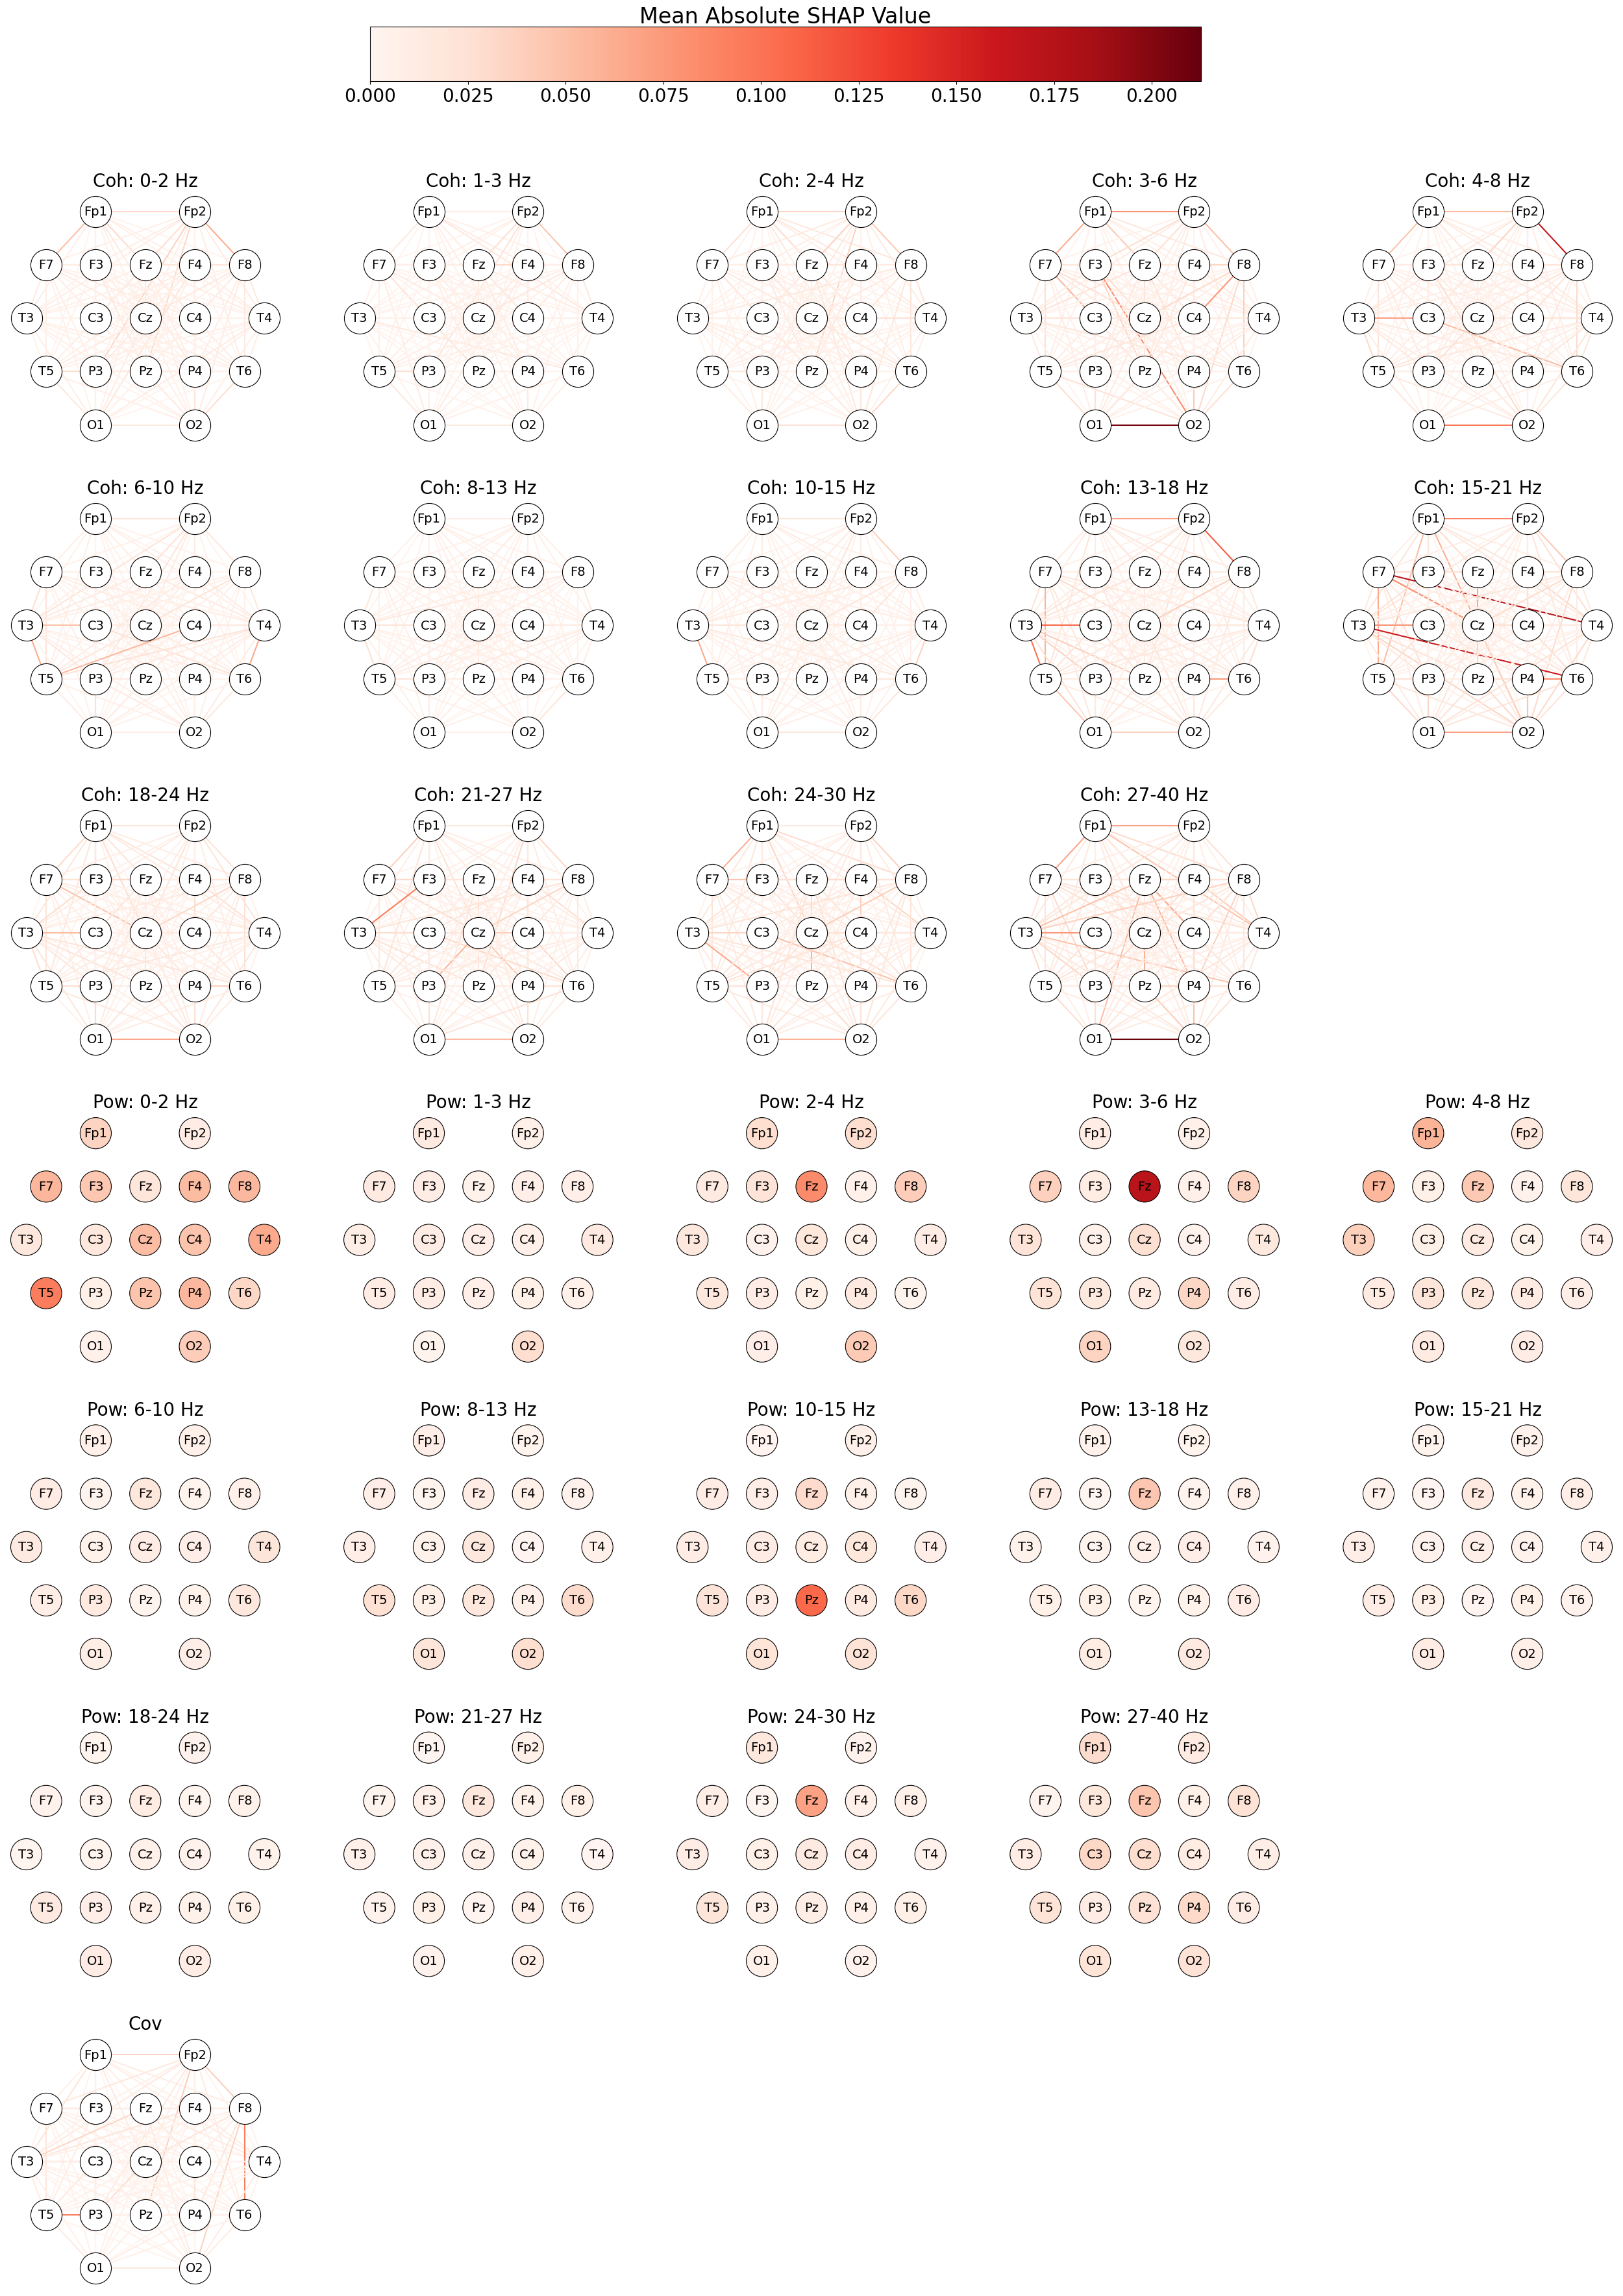

In [11]:
fig, axs = plot_eeg_feature_overview(shap_values.mean(axis=0))
#fig.suptitle("Average Impact of EEG Features (Mean SHAP Values)", fontsize=16)
#fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust top of rect for suptitle
plt.savefig('results/figures/mean_shap_eeg_feature_overview.png', dpi=100)

In [13]:
top_n = 20
top_features = shap_values.mean(axis=0).sort_values(ascending=False).head(top_n).index

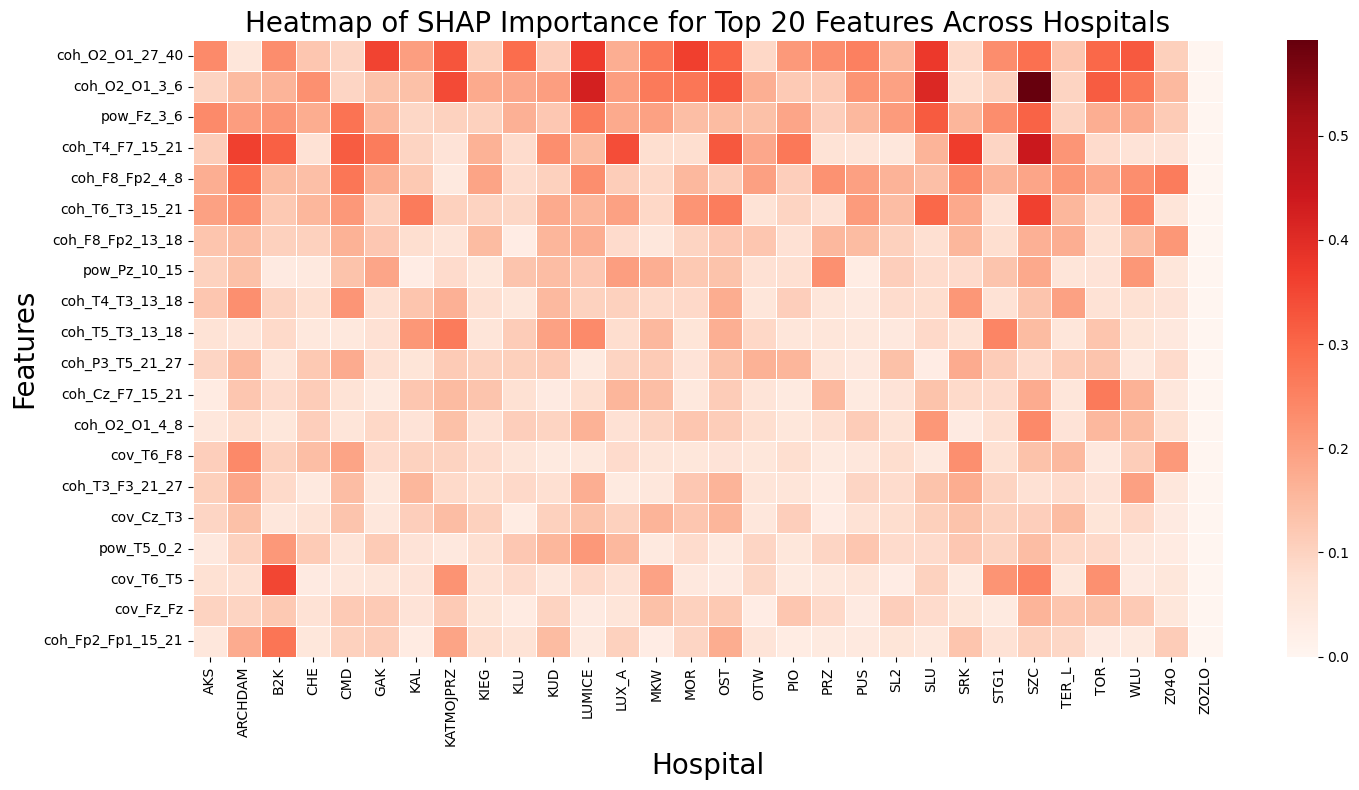

In [15]:
shap_values_for_heatmap = shap_values[top_features]

plt.figure(figsize=(15, 8))
sns.heatmap(shap_values_for_heatmap.T,
            yticklabels=top_features,
            xticklabels=hospital_names,
            annot=False,
            cmap="Reds",
            vmin=0,
            linewidths=.5)
plt.title(f'Heatmap of SHAP Importance for Top {top_n} Features Across Hospitals', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.xlabel('Hospital', fontsize=20)
plt.tight_layout()
#plt.savefig('results/figures/hospital_classification_top_n_shap.png', dpi=300)
plt.show()

In [17]:
global_vmin, global_vmax = 0, 0.35

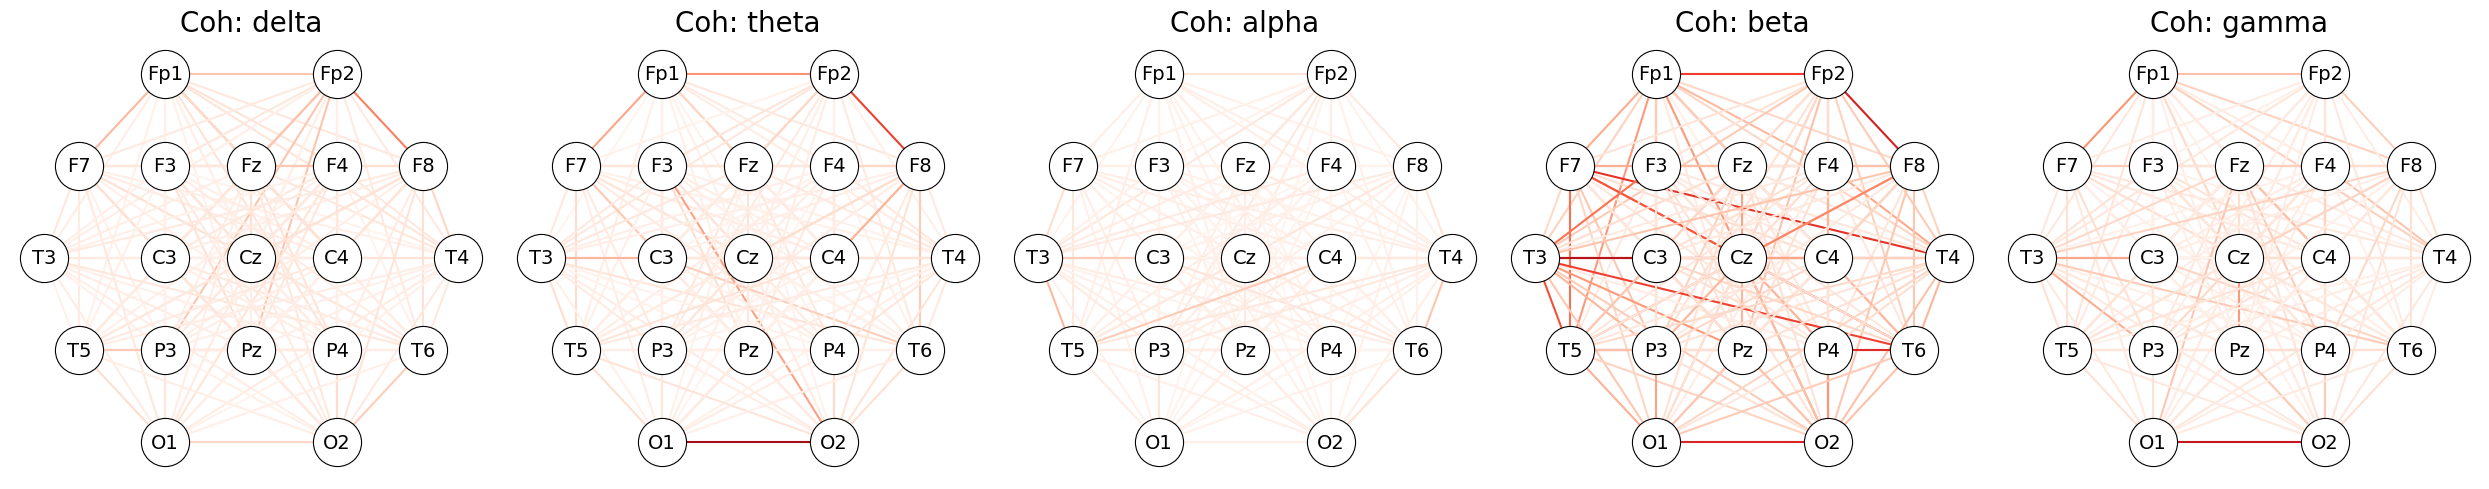

In [18]:
FREQ_BANDS_NAMES = {
    'delta': [[0.5, 2], [1, 3], [2, 4]],
    'theta': [[3, 6], [4, 8]],
    'alpha': [[6, 10], [8, 13]],
    'beta': [[10, 15], [13, 18], [15, 21], [18, 24], [21, 27]],
    'gamma': [[24, 30], [27, 40]]
}

fig, axs = plt.subplots(1, 5, figsize=(25, 5), squeeze=False)
axs = axs.flatten()
for i, (band, freqs) in enumerate(FREQ_BANDS_NAMES.items()):
    summed_series = None
    for (f_low, f_high) in freqs:
        series = extract_hospital_features(shap_values.mean(axis=0), f"coh_{int(float(f_low))}_{int(float(f_high))}")
        
        if summed_series is None:
            summed_series = series.copy()
        else:
            summed_series = summed_series.add(series, fill_value=0)        
    #print(summed_series.max())
    ax = axs[i]
    plot_electrode_pairs(
            summed_series, 
            ax, 
            f"Coh: {band}", 
            channels, 
            vmin=global_vmin, 
            vmax=global_vmax
    )
plt.tight_layout()

#norm = mcolors.Normalize(vmin=global_vmin, vmax=global_vmax)
#sm = mcm.ScalarMappable(cmap='Reds', norm=norm)
#sm.set_array([])
#plt.tight_layout(rect=[0, 0, 0.9, 1]) # [left, bottom, right, top]
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#fig.colorbar(sm, cax=cbar_ax, orientation='vertical')

plt.savefig('results/figures/shap_analysis/hospital_classification_coh_bands.png', dpi=400)
plt.show()

In [15]:
shap_values.mean()

coh_Fp2_Fp1_0_2    0.030380
coh_F7_Fp1_0_2     0.049424
coh_F7_Fp2_0_2     0.006487
coh_F3_Fp1_0_2     0.006653
coh_F3_Fp2_0_2     0.009963
                     ...   
cov_O2_Pz          0.007717
cov_O2_P4          0.001447
cov_O2_T6          0.012649
cov_O2_O1          0.015034
cov_O2_O2          0.040933
Length: 2850, dtype: float64

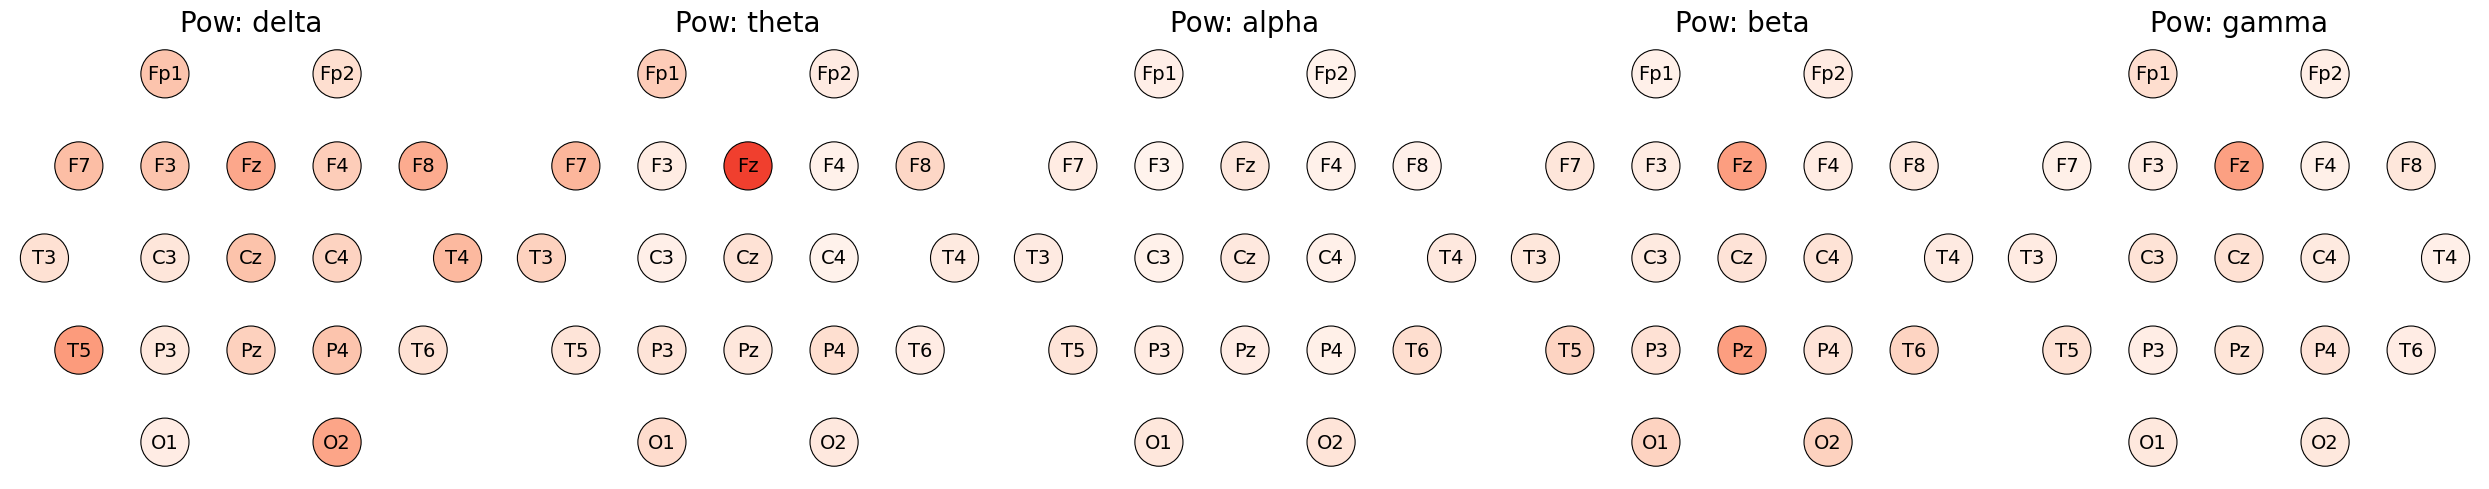

In [20]:
FREQ_BANDS_NAMES = {
    'delta': [[0.5, 2], [1, 3], [2, 4]],
    'theta': [[3, 6], [4, 8]],
    'alpha': [[6, 10], [8, 13]],
    'beta': [[10, 15], [13, 18], [15, 21], [18, 24], [21, 27]],
    'gamma': [[24, 30], [27, 40]]
}

fig, axs = plt.subplots(1, 5, figsize=(25, 5), squeeze=False)
axs = axs.flatten()
for i, (band, freqs) in enumerate(FREQ_BANDS_NAMES.items()):
    summed_series = None
    for (f_low, f_high) in freqs:
        series = extract_hospital_features(shap_values.mean(axis=0), f"pow_{int(float(f_low))}_{int(float(f_high))}")
        
        if summed_series is None:
            summed_series = series.copy() 
        else:
            summed_series = summed_series.add(series, fill_value=0)        
    #print(summed_series.max())
    ax = axs[i]
    plot_channel_values_as_nodes(
            summed_series, 
            ax,
            f"Pow: {band}",
            channels, 
            vmin=global_vmin, 
            vmax=global_vmax
    )

plt.tight_layout()

# norm = mcolors.Normalize(vmin=global_vmin, vmax=global_vmax)
# sm = mcm.ScalarMappable(cmap='Reds', norm=norm)
# sm.set_array([])
# plt.tight_layout(rect=[0, 0, 0.9, 1]) # [left, bottom, right, top]
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
plt.savefig('results/figures/shap_analysis/hospital_classification_pow_bands.png', dpi=400)
plt.show()

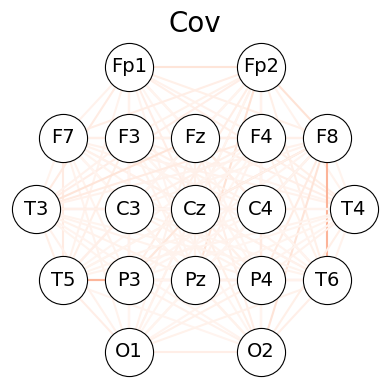

In [25]:
fig, ax = plt.subplots(1, figsize=(4, 4), squeeze=False)

series = extract_hospital_features(shap_values.mean(axis=0), f"cov")
#print(series.max())
plot_electrode_pairs(series, ax[0,0], f"Cov", channels, vmin=global_vmin, vmax=global_vmax)
plt.tight_layout()
# norm = mcolors.Normalize(vmin=global_vmin, vmax=global_vmax)
# sm = mcm.ScalarMappable(cmap='Reds', norm=norm)
# sm.set_array([])
# plt.tight_layout(rect=[0, 0, 0.9, 1]) # [left, bottom, right, top]
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
plt.savefig('results/figures/shap_analysis/hospital_classification_cov.png', dpi=400)
plt.show()